In [1]:
# import all libraries you need here
import pandas as pd
import numpy as np
import pathlib as pl
import harmonypy as hm

import scanpy as sc

In [2]:
random_seed = 42
np.random.seed(random_seed)
sc.settings.seed = random_seed

# Step 0: Download the data

In [3]:
bulk_train_x = pd.read_csv("train_data/train_bulk.csv", index_col=0)
bulk_train_y = pd.read_csv("train_data/train_bulk_trueprops.csv", index_col=0)
bulk_test_x = pd.read_csv("test_data/test_bulk.csv", index_col=0)

In [4]:
sc_train = sc.read_h5ad("train_data/train_adata.h5ad")
sc_test = sc.read_h5ad("test_data/test_adata.h5ad")

In [5]:
print(sc_train.var.shape) # gene level
sc_train.var.head()

(7725, 6)


,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


In [6]:
print(sc_train.obs.shape) # cell level
sc_train.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [7]:
print(sc_train.X.shape) # expression of the cells by genes

(32374, 7725)


# Step 1: Perform SC clustering 

In [8]:
# Preprocessing
def sc_preprocess(sc_data):
    sc.pp.filter_cells(sc_data, min_genes=200)
    sc.pp.filter_genes(sc_data, min_cells=3)
    sc_data = sc_data[sc_data.obs['pct_counts_mt'] < 10]

    sc.pp.normalize_total(sc_data, target_sum=1e4)
    sc.pp.log1p(sc_data)

    sc.pp.normalize_total(sc_data, target_sum=1e4)
    sc.pp.log1p(sc_data)

    sc.pp.highly_variable_genes(sc_data, n_top_genes=2000, batch_key="Sample")
    sc_data = sc_data[:, sc_data.var['highly_variable']]

    sc.pp.scale(sc_data, max_value=10)
    return sc_data

sc_train = sc_preprocess(sc_train)

c:\Users\edonn\miniconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


c:\Users\edonn\miniconda3\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
c:\Users\edonn\miniconda3\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [9]:
# PCA
sc.tl.pca(sc_train, svd_solver='arpack')

In [10]:
# Harmony batch correction
ho = hm.run_harmony(sc_train.obsm['X_pca'], sc_train.obs, 'Sample')
sc_train.obsm['X_pca_harmony'] = ho.Z_corr.T

2025-11-21 10:40:59,680 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-21 10:41:11,523 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-21 10:41:11,683 - harmonypy - INFO - Iteration 1 of 10
2025-11-21 10:41:21,846 - harmonypy - INFO - Iteration 2 of 10
2025-11-21 10:41:32,251 - harmonypy - INFO - Iteration 3 of 10
2025-11-21 10:41:42,821 - harmonypy - INFO - Iteration 4 of 10
2025-11-21 10:41:49,492 - harmonypy - INFO - Iteration 5 of 10
2025-11-21 10:41:55,443 - harmonypy - INFO - Converged after 5 iterations


In [11]:
sc.pp.neighbors(sc_train, use_rep='X_pca_harmony')

c:\Users\edonn\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
sc.tl.leiden(sc_train, resolution=0.5)

C:\Users\edonn\AppData\Local\Temp\ipykernel_23408\3145417138.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sc_train, resolution=0.5)


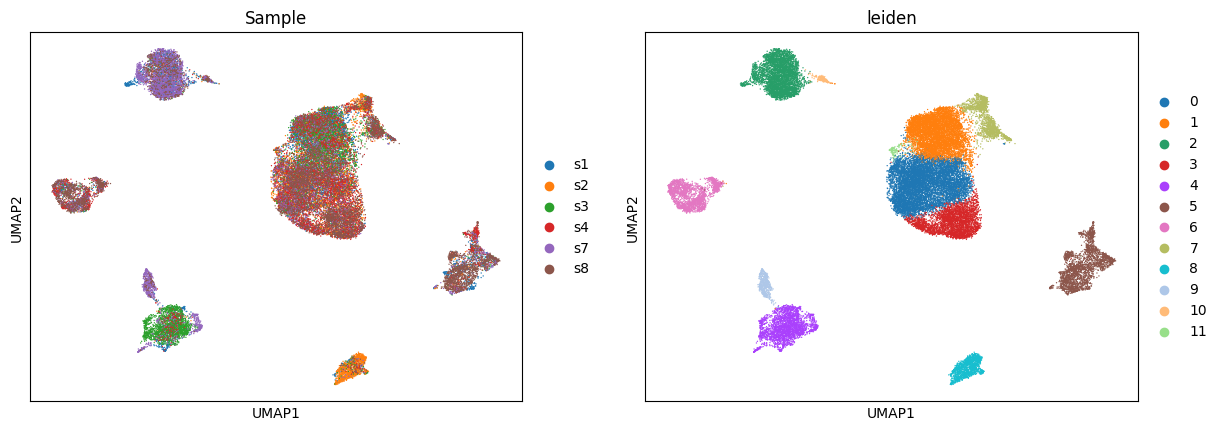

In [13]:
#visualization
sc.tl.umap(sc_train, min_dist=0.3)
sc.pl.umap(sc_train, color=['Sample', 'leiden'])

# Step 2: Deconvolve the data

In [14]:
# for each cell type x, cacluate x_gene_expression = x_cell_percentage * sum(over all clusters assigned to cell type x) (cluster_cell_percentage * cluster_expression_matrix)

# Step 2bis: Predict on the test data

# Step 3: Save the required files

In [15]:
# pred_props should be a DataFrame containing the estimated cell type proportions for the patients in all_bulkified
# pred_props.columns = ['index','s5_0','s5_1',...,'s10_3','s10_4'] = np.append(["index"],all_bulkified.columns)
# pred_props['index'] = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
#       'NK', 'Myeloid', 'Mast']

In [16]:
results_path = pl.Path("path/to/your/results")

In [17]:
assert all(pred_props.columns == np.append(["index"],all_bulkified.columns)), "Wrong columns"

NameError: name 'pred_props' is not defined

In [ ]:
assert all(pred_props['index']== ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
       'NK', 'Myeloid', 'Mast']), "Wrong order for cell types"

In [ ]:
assert all(pred_props.drop("index",axis=1).sum().round()==1), "The proportions for a single patient must sum to 1"

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [ ]:
assert all(cluster_labels.columns == ["index", "cluster"]), "Wrong columns"

In [ ]:
assert all(cluster_labels["index"] == test_adata.obs_names), "The cell ids are either not all present or not in the right order"

In [ ]:
import zipfile

archive_name = "Negri_Edoardo_Project2.zip" # TODO

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        pred_props.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()